<a href="https://colab.research.google.com/github/Himnshii/ML-Projects/blob/main/Document%20Clustering/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.metrics import silhouette_samples, adjusted_rand_score


Load and Prepare the Data

In [ ]:
# Load dataset (removing headers, footers, and quotes for cleaner text)
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data


Preprocess Text with Lemmatization
python
Copy code


In [ ]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = re.findall(r'\b[a-z]{3,}\b', text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

processed_docs = [preprocess(doc) for doc in documents]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Vectorize

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
X_tfidf = vectorizer.fit_transform(documents)


Elbow Method – To determine optimal number of clusters

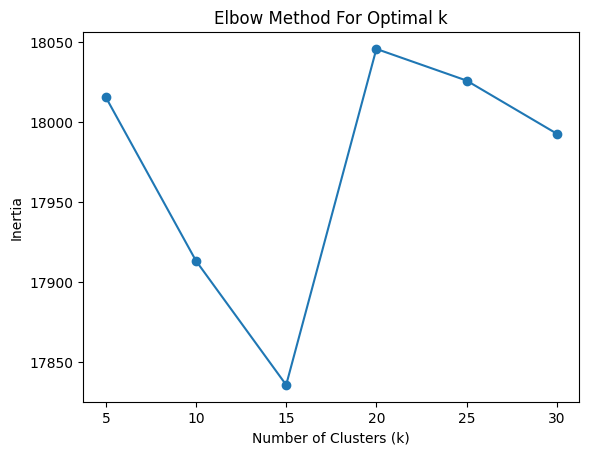

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

inertias = []
cluster_range = range(5, 31, 5)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


 Apply K-Means Clustering

In [ ]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_tfidf)
labels = kmeans.labels_


Evaluate Clustering Quality


a.Silhouette Score

In [ ]:
sil_score = silhouette_score(X_tfidf, labels)
print(f"Silhouette Score for KMeans with {num_clusters} clusters: {sil_score:.3f}")


Silhouette Score for KMeans with 20 clusters: 0.002


b.Silhouette Score Distribution

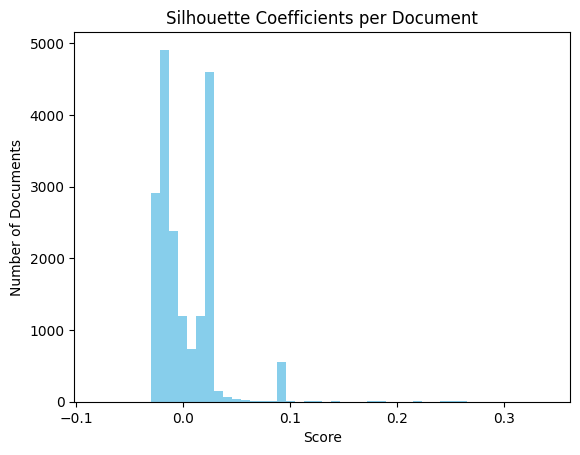

In [ ]:
sil_values = silhouette_samples(X_tfidf, labels)
plt.hist(sil_values, bins=50, color='skyblue')
plt.title("Silhouette Coefficients per Document")
plt.xlabel("Score")
plt.ylabel("Number of Documents")
plt.show()


Adjusted Rand Index (vs. True Labels)

In [ ]:
true_labels = newsgroups.target
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari:.3f}")


Adjusted Rand Index: 0.081


Top Terms per Cluster

In [ ]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Cluster 0: thanks, advance, mail, know, does, hi, info, email, looking, address
Cluster 1: edu, does, com, think, know, don, new, like, did, sure
Cluster 2: church, christian, religion, bible, christians, people, christianity, god, homosexual, faith
Cluster 3: window, program, motif, server, application, file, display, widget, manager, use
Cluster 4: drive, hard, disk, drives, floppy, ide, controller, hd, meg, problem
Cluster 5: card, monitor, pc, video, mac, software, apple, graphics, use, bit
Cluster 6: god, believe, bible, existence, people, does, faith, belief, christians, know
Cluster 7: people, don, think, just, gun, know, right, government, like, say
Cluster 8: jesus, god, christ, sin, bible, christian, mary, people, life, christians
Cluster 9: just, like, space, time, good, use, ve, know, don, think
Cluster 10: 00, sale, shipping, offer, condition, price, asking, new, 10, sell
Cluster 11: dsl, n3jxp, cadre, chastity, geb, skepticism, intellect, shameful, pitt, surrender
Cluster

Visualize Clusters in 2D

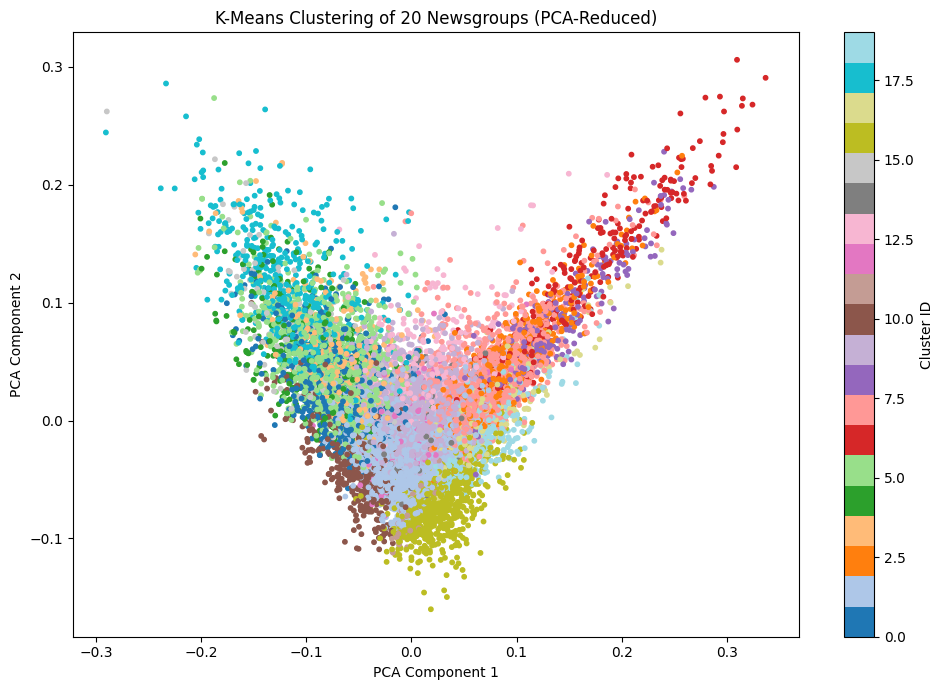

In [ ]:
X_dense = X_tfidf.toarray()
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=10)
plt.title("K-Means Clustering of 20 Newsgroups (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.tight_layout()
plt.show()


 Save Clustered Output to CSV

In [ ]:
df = pd.DataFrame({'document': documents, 'cluster': labels})
df.to_csv('kmeans_clustered_documents.csv', index=False)
